# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

**Estimated Run Time:** 

This notebooks outlines the process of generating unbiased candidate mechanisms and comparing them to the dogmatic mechanisms from the NeuroMMSig Database.

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from matplotlib_venn import venn2
import itertools as itt
from collections import defaultdict
import logging
import pybel
from pybel.constants import *
from pybel.canonicalize import calculate_canonical_name
import pybel_tools as pbt
from pybel_tools.visualization import to_jupyter
import pybel_tools.analysis.npa as npa

import seaborn as sns

#%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
pybel.__version__

'0.4.1'

In [3]:
pbt.__version__

'0.1.3-dev'

In [4]:
bms_base = os.environ['BMS_BASE']
owncloud_base = os.environ['OWNCLOUD_BASE']

# Data

## Alzheimer's Disease Knowledge Assembly

The Alzheimer's Disease knowledge assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [5]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')

In [6]:
graph = pybel.from_pickle(pickle_path)

# Workflow

## Canonical Mechanisms

The names of the canonical mechanisms are extracted and listed below.

In [7]:
canonical_mechanism_names = pbt.summary.get_annotation_values(graph, 'Subgraph')
canonical_mechanism_names 

{'AD T2DM SNPs',
 'ADAM Metallopeptidase subgraph',
 'ATP binding cassette transport subgraph',
 'Acetylcholine signaling subgraph',
 'Akt subgraph',
 'Albumin subgraph',
 'Alcohol dehydrogenase subgraph',
 'Alpha 2 macroglobulin subgraph',
 'Amylin subgraph',
 'Amyloidogenic subgraph',
 'Androgen subgraph',
 'ApoE subgraph',
 'Apoptosis signaling subgraph',
 'Autophagy signaling subgraph',
 'Axonal guidance subgraph',
 'Axonal transport subgraph',
 'Bcl-2 subgraph',
 'Beta secretase subgraph',
 'Beta-Catenin subgraph',
 'Beta-Oxidation of Fatty Acids',
 'Binding and Uptake of Ligands by Scavenger Receptors',
 'Blood vessel dilation subgraph',
 'CREB subgraph',
 'CRH subgraph',
 'Calcium-dependent signal transduction',
 'Calpastatin-calpain subgraph',
 'Calsyntenin subgraph',
 'Caspase subgraph',
 'Cell adhesion subgraph',
 'Cell cycle subgraph',
 'Cell-cell communication subgraph',
 'Chaperone subgraph',
 'Chemokine signaling subgraph',
 'Cholesterol metabolism subgraph',
 'Complement

The BEL graph object is split to multiple BEL graph objects representing each of the subgraphs with [pbt.selection.get_subgraph_by_annotation](http://pybel-tools.readthedocs.io/en/latest/selection.html#pybel_tools.selection.get_subgraph_by_annotation).

In [8]:
%%time

canonical_mechanisms = {}
for sg in canonical_mechanism_names:
    m = pbt.selection.get_subgraph_by_annotation(graph, sg)
    canonical_mechanisms[sg] = m

CPU times: user 13.4 s, sys: 27.4 ms, total: 13.5 s
Wall time: 13.5 s


### Exploration of Biological Processes in Dogmatic Mechanisms

All biological process nodes are retrieved with [pbt.selection.get_nodes_by_function](http://pybel-tools.readthedocs.io/en/latest/selection.html#pybel_tools.selection.get_nodes_by_function).

In [9]:
bioprocess_nodes = set(pbt.selection.get_nodes_by_function(graph, BIOPROCESS))
len(bioprocess_nodes)

440

Which bioprocesses appear in multiple canonical mechanisms? The upstream controllers of these nodes in the knowledge assembly will be direct evidence for cross talk.

In [10]:
bp2sg = defaultdict(set)

for cm, m in canonical_mechanisms.items():
    for bp in pbt.selection.get_nodes_by_function(m, BIOPROCESS):
        bp2sg[bp].add(cm)

In [11]:
for bp, sgs in sorted(bp2sg.items(), key=lambda x: len(x[1]), reverse=True):
    if 2 <= len(sgs):
        print('{:2} {:6} {}'.format(len(sgs), graph.node[bp][NAMESPACE], graph.node[bp][NAME]))

42 GOBP   apoptotic process
30 GOBP   neuron apoptotic process
28 GOBP   neuron death
26 GOBP   cognition
24 GOBP   cell death
20 GOBP   memory
20 GOBP   inflammatory response
20 MESHPP Oxidative Stress
15 GOBP   calcium ion import
14 GOBP   microglial cell activation
14 GOBP   response to oxidative stress
12 MESHPP Apoptosis
12 GOBP   learning
11 GOBP   regulation of synaptic plasticity
11 MESHPP Insulin Resistance
10 GOBP   calcium-mediated signaling
10 GOBP   negative regulation of neuron apoptotic process
10 GOBP   microglial cell activation involved in immune response
10 GOBP   insulin receptor signaling pathway
10 GOBP   endocytosis
 9 GOBP   long-term synaptic potentiation
 9 GOBP   cytoskeleton organization
 9 GOBP   neuron projection development
 9 MESHPP Neurogenesis
 9 GOBP   synaptic transmission
 9 GOBP   beta-amyloid formation
 8 GOBP   calcium ion homeostasis
 8 GOBP   beta-amyloid clearance
 8 GOBP   mitochondria-nucleus signaling pathway
 8 GOBP   negative regulation o

Conversely, how many biological processes appear in each mechanism?

In [12]:
sg2bp = {}

for cm, m in canonical_mechanisms.items():
    sg2bp[cm] = set(pbt.selection.get_nodes_by_function(m, BIOPROCESS))

In [13]:
for cm, bps in sorted(sg2bp.items(), key=lambda x: len(x[1]), reverse=True):
    print('{:2} {}'.format(len(bps), cm))

97 Amyloidogenic subgraph
64 Insulin signal transduction
43 Inflammatory response subgraph
42 Tau protein subgraph
36 Low density lipoprotein subgraph
34 Gamma secretase subgraph
33 Acetylcholine signaling subgraph
30 MAPK-ERK subgraph
29 Non-amyloidogenic subgraph
29 Cyclin-CDK subgraph
28 Glutamatergic subgraph
26 Reactive oxygen species subgraph
25 Calcium-dependent signal transduction
23 Tumor necrosis factor subgraph
22 Phosphatidylinositol 3 subgraph
22 Regulation of cytoskeleton subgraph
21 GSK3 subgraph
21 Chemokine signaling subgraph
21 Nitric oxide subgraph
21 Interleukin signaling subgraph
20 Caspase subgraph
19 ApoE subgraph
19 Response to oxidative stress
19 CREB subgraph
17 Endosomal lysosomal subgraph
16 Apoptosis signaling subgraph
16 Notch signaling subgraph
15 MAPK-JNK subgraph
15 miRNA subgraph
15 Nerve growth factor subgraph
14 Electron transport chain
14 NMDA receptor
14 Beta secretase subgraph
13 Unfolded protein response subgraph
13 Synapse assembly subgraph
13 S

Show a heatmap, organized by dendrograms

In [14]:
bp_sg_membership = defaultdict(dict)

for cm, m in canonical_mechanisms.items():
    for bp in bioprocess_nodes:
        bp_sg_membership[bp][cm] = 1 if bp in sg2bp[cm] else 0

membership_df = pd.DataFrame(bp_sg_membership)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


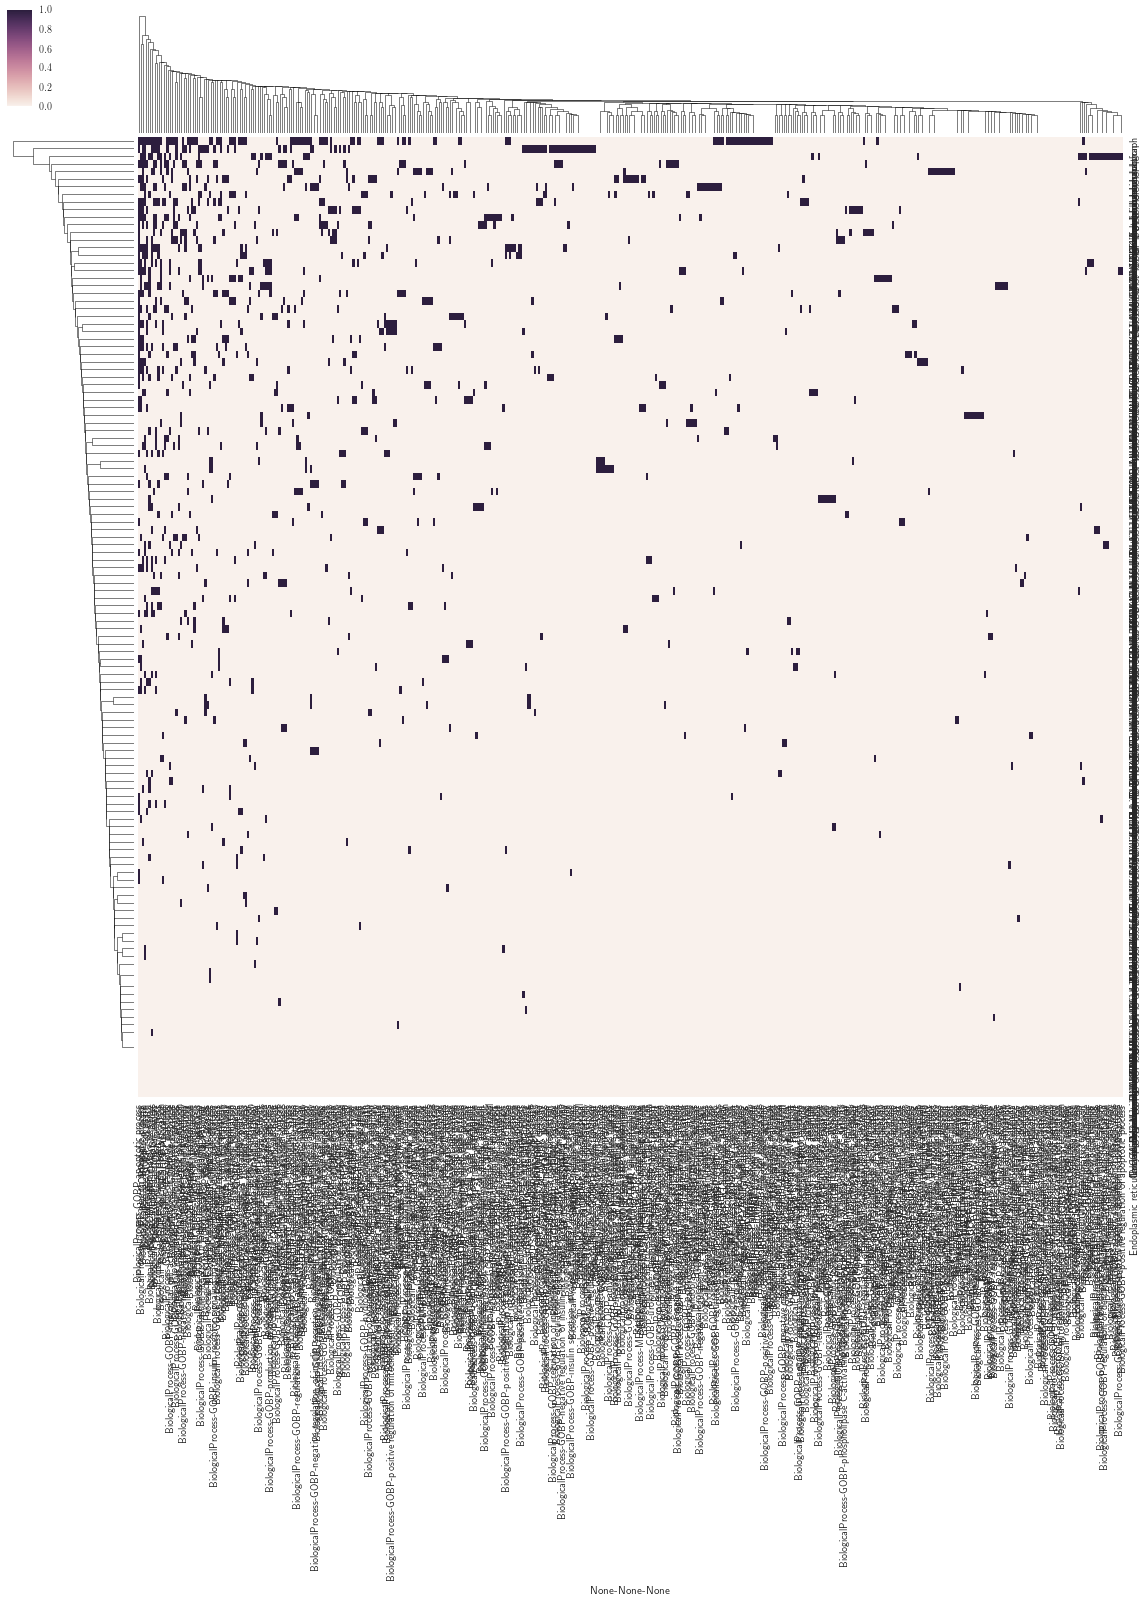

In [15]:
sns.clustermap(membership_df, figsize=(20, 20))
plt.show()

## Generated Unbiased Mechanisms

Each subgraph annotation in the NeuroMMSig Database comes from a specific domain of study.While these dogmatic mechanisms are helpful for communicating ideas, they are a discretization of the continuous and inseperable biological system. In this section, we will generate more, smaller candidate subgraphs with an unbiased approach in hopes of providing a more thorough overview of the individual mechanisms in the hollistic system and their interplay or "cross-talk". Later, we'll use that information to assess the overlap between dogmatic mechanisms and bridge the gaps between them.

The mechanisms themselves are generated with [pbt.generation.generate_mechanism](http://pybel-tools.readthedocs.io/en/latest/generation.html#pybel_tools.generation.generate_mechanism).

In [16]:
%%time

candidate_mechanisms = {}
for bp in bioprocess_nodes:
    candidate_mechanisms[bp] = pbt.generation.generate_mechanism(graph, bp)

CPU times: user 3.17 s, sys: 31.4 ms, total: 3.2 s
Wall time: 3.2 s


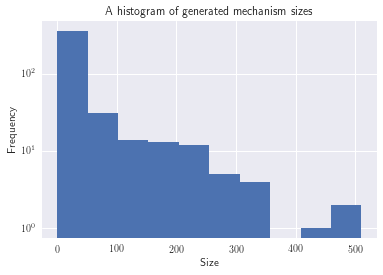

In [17]:
plt.title('A histogram of generated mechanism sizes')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.hist([len(cm) for cm in candidate_mechanisms.values()], log=True)
plt.show()

## Comparison

In [18]:
%%time

results = defaultdict(dict)

for candidate, canonical in itt.product(sorted(candidate_mechanisms), sorted(canonical_mechanisms)):
    candidate_nodes = set(candidate_mechanisms[candidate].nodes_iter())
    canonical_nodes = set(canonical_mechanisms[canonical].nodes_iter())
    tanimoto = pbt.utils.tanimoto_set_similarity(candidate_nodes, canonical_nodes)
    results[candidate][canonical] = tanimoto

overlap_df = pd.DataFrame(results)

CPU times: user 4.38 s, sys: 35.3 ms, total: 4.42 s
Wall time: 4.43 s


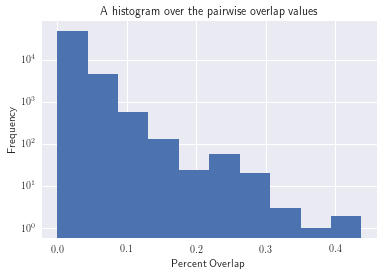

In [19]:
plt.title('A histogram over the pairwise overlap values')
plt.xlabel('Percent Overlap')
plt.ylabel('Frequency')
plt.hist(overlap_df.as_matrix().ravel(), log=True)
plt.show()

In [20]:
overlap_df.to_csv(os.path.expanduser('~/Desktop/subgraph_comparison.csv'))

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


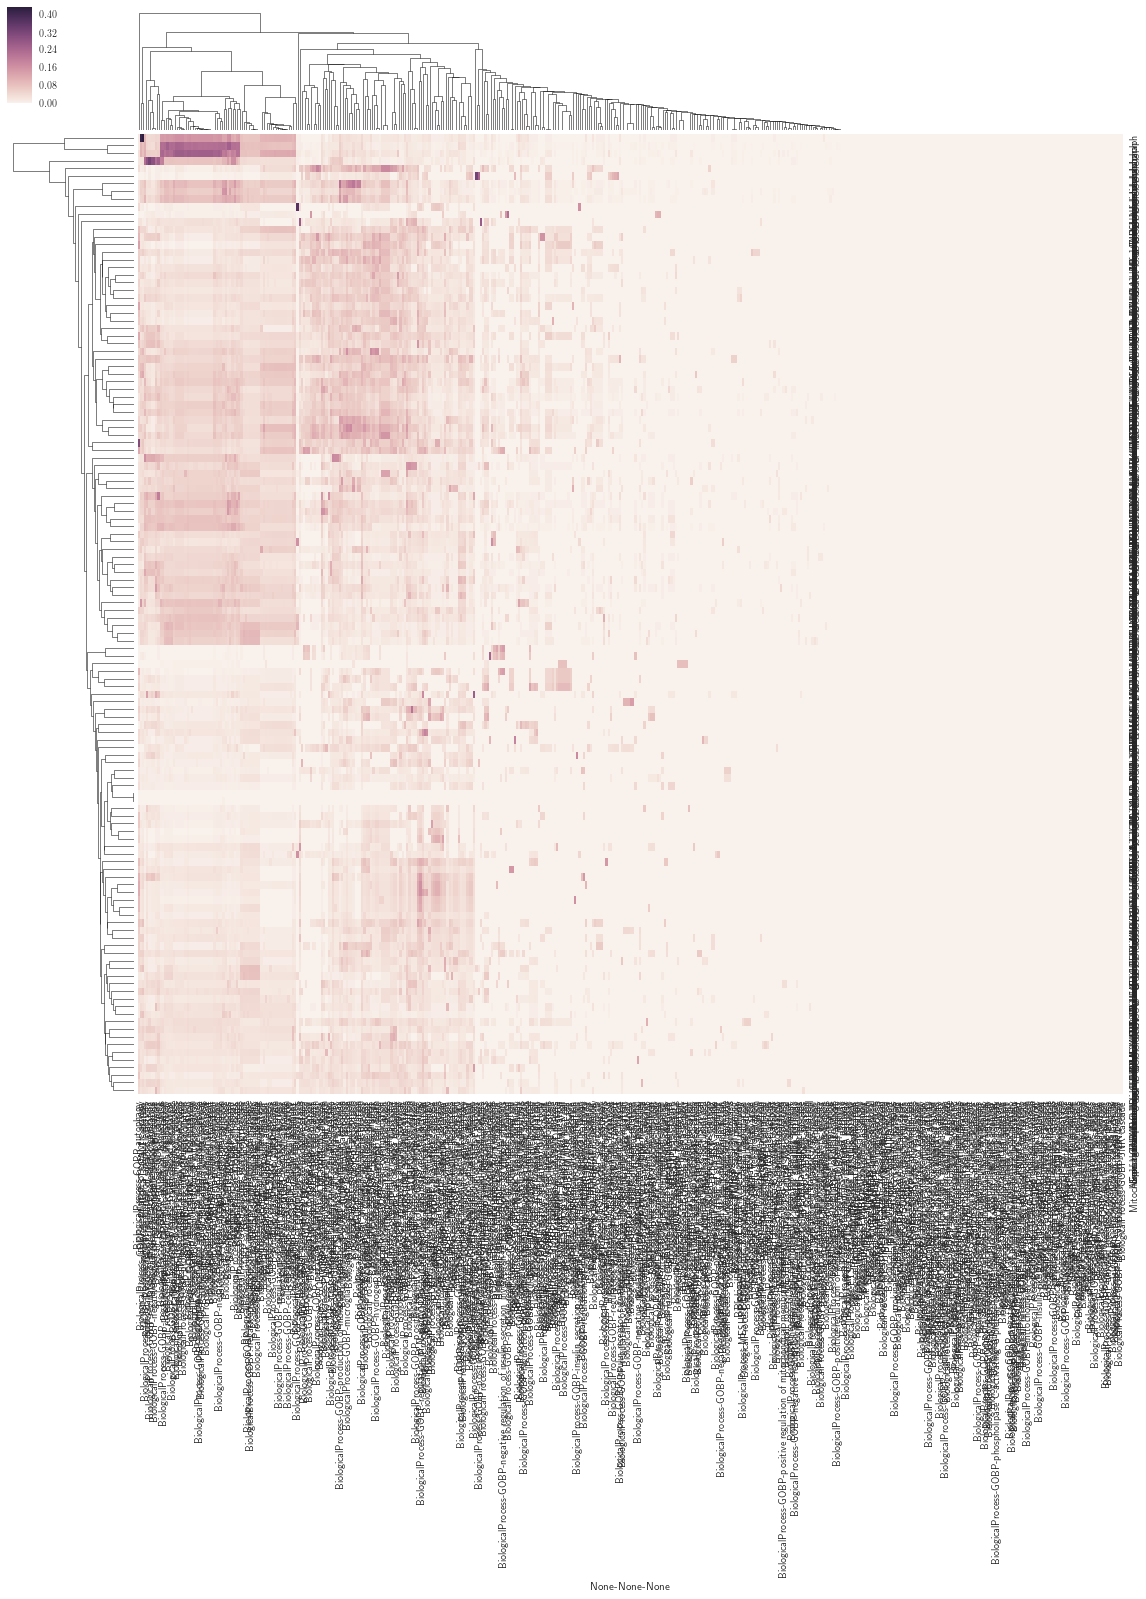

In [21]:
sns.clustermap(overlap_df, figsize=(20, 20))
plt.show()

Bioprocesses will be annotated to subgraphs if they have more than the given cutoff similarity.

In [22]:
cutoff = .20
sg2bp_cutoff = defaultdict(set)
for candidate, canonical in itt.product(sorted(candidate_mechanisms), sorted(canonical_mechanisms)):
    if not canonical in results or candidate not in results[canonical]:
        continue
    if results[canonical][candidate] > cutoff:
        sg2bp_cutoff[canonical].add(candidate)
        
cutoff_df = pd.DataFrame(sg2bp_cutoff)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


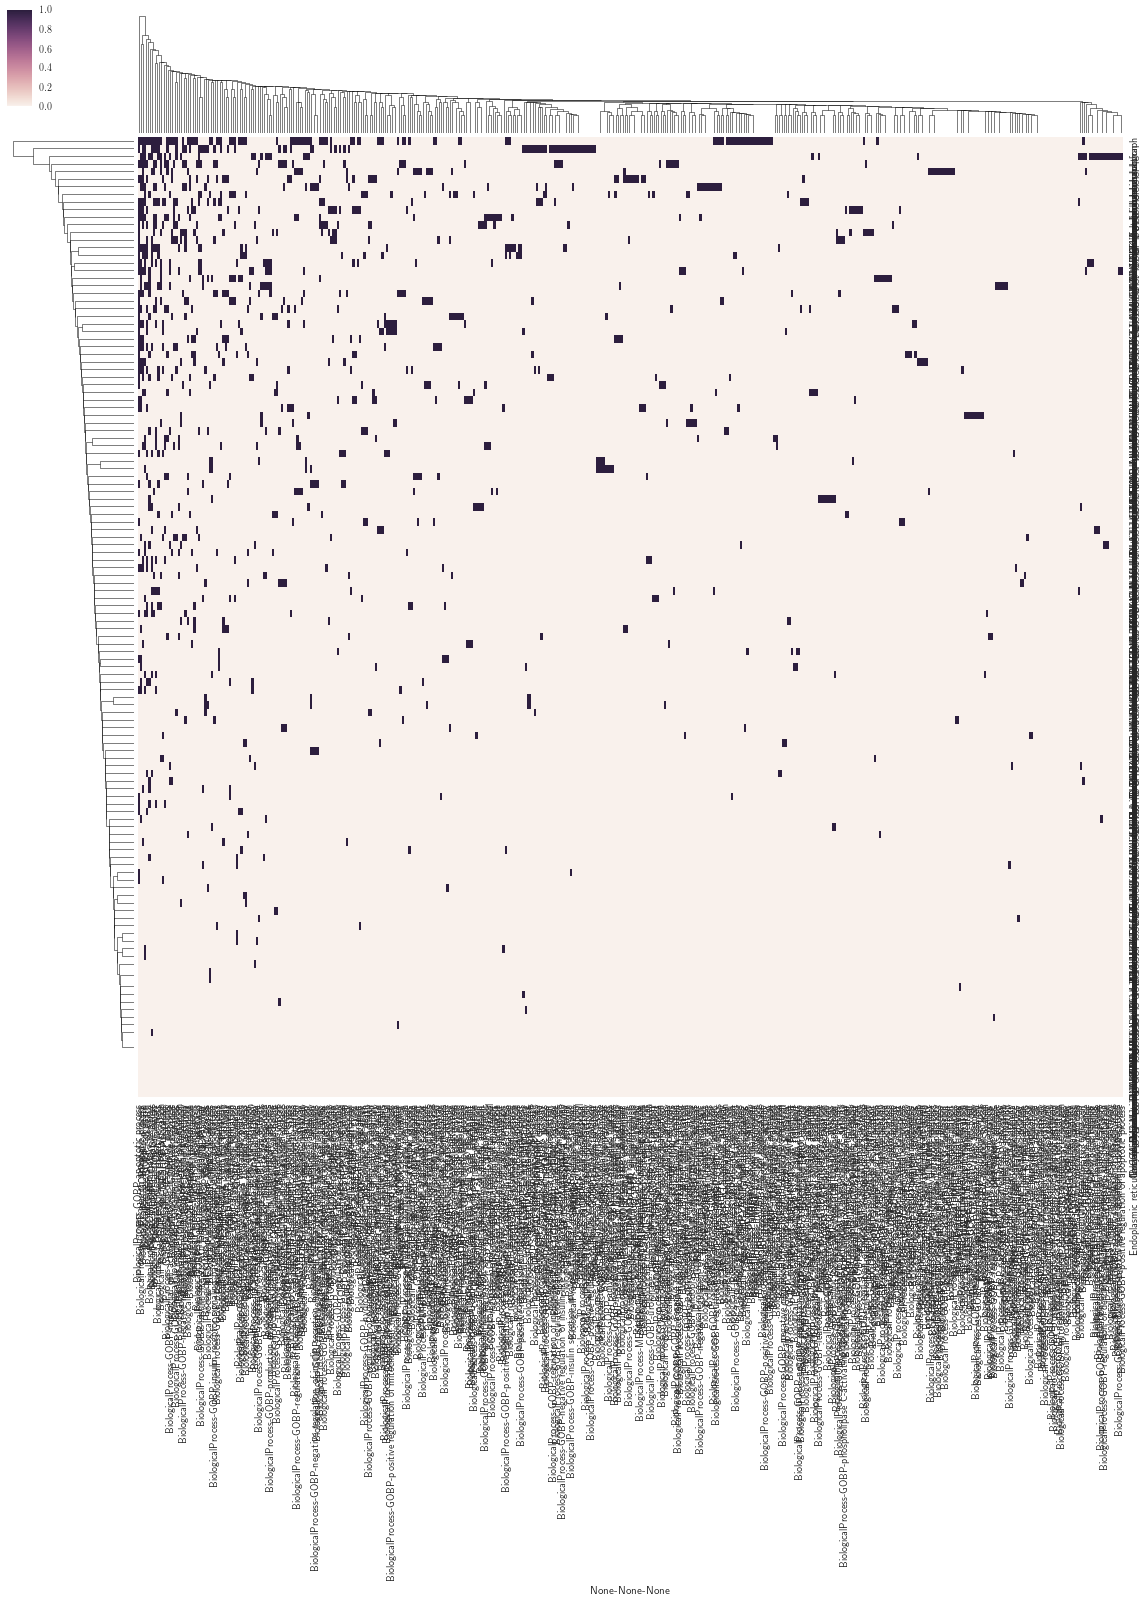

In [23]:
sns.clustermap(membership_df, figsize=(20, 20))
plt.show()

How often do these assignments match canonical subgraph membership?

In [ ]:
# TODO